# Initial Implementation
## Helper Functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time 
import pandas as pd
import seaborn as sns

def gaussian_pyramid(image):
    template_options = []
    #Creat Gaussian Scaled Images
    layer = image.copy()
    for x in range(5):
        layer = cv2.pyrDown(layer)
        template_options.append(layer)
        
    return template_options
    
def random_colour():
    return (random.randint(0, 150), random.randint(0, 150), random.randint(0, 150))

#Find coordinates for a single template and returns image with bounding box
def single_template_match(target, template_options, key):
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    colour = random_colour()
    text_coord = []
    template_option = template_options[2]
    h, w = template_option.shape
    threshold = 0.95
    
    #Template Match
    res = cv2.matchTemplate(target_gray, template_option, cv2.TM_CCOEFF_NORMED)
    #Only return points where the probability of a template occuring is above 95%
    loc = np.where(res >= threshold)
    
    #Bound found template in image
    for pt in zip(*loc[::-1]):
        text_coord.append(pt)
        cv2.rectangle(target, pt, (pt[0] + w, pt[1] + h), colour, 2)
    
    return target, text_coord

#Finds coordinates for all templates in an image and draws text accordingly
def total_temp_matching(test_image, template_dict):
    target = test_image
    keys = template_dict.keys()
    text_coords = []
    
    for key in keys:
        template_options = template_dict[key]
        target, text_coord = single_template_match(target, template_options, key)
        text_coords.append(text_coord)
    
    
    for index in range(len(text_coords)):
        #Draw Text
        if text_coords[index]:
            cv2.putText(img=target, text=list(keys)[index], org=(text_coords[index][0][0],text_coords[index][0][1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)
            cv2.putText(img=target, text=list(keys)[index], org=(text_coords[index][0][0],text_coords[index][0][1]+75), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)
    return target   
    

## Applying template matching to all images

In [7]:
# Load the template image and the target image
target = cv2.imread('Task2Dataset/TestWithoutRotations/images/test_image_12.png')


#Make Template Classes
directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()

for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr

#Testing Classes
directory_test = "Task2Dataset/TestWithoutRotations/images"
test_images_numbers = []
image_results = []
results = []
runtimes = []


for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    image_number = f.partition("_")[2].partition("_")[2].partition(".")[0]
    test_images_numbers.append(image_number)
    time_1 = time.time()
    image_results.append(total_temp_matching(cv2.imread(f), template_dict))
    runtimes.append(time.time()-time_1)






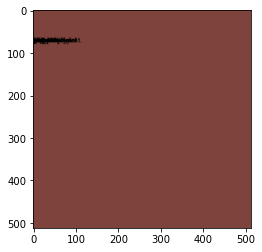

KeyboardInterrupt: Interrupted by user

In [8]:
for image in image_results:
    plt.figure()
    plt.imshow(image)
    plt.show()
    results.append(input())

## Testing Accuracy vs Threshold

In [171]:
target = cv2.imread("/Users/louisgodtfredsen/Desktop/Work/BATH/Year_3/ComputerVision/Task2Dataset/TestWithoutRotations/images/test_image_1.png")


In [150]:
#Make Template Classes
directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()
key = "house"
for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr
    
template_options = template_dict[key]
target, text_coord = single_template_match(target, template_options, key)

In [23]:
#Function used to calculate IOU from coordinates of two detected points
def calc_iou(boxA_coord, boxB_coord, w, h):
    
    boxA = [boxA_coord[0],boxA_coord[1], boxA_coord[0]+w, boxA_coord[1]+h]
    boxB = [boxB_coord[0],boxB_coord[1], boxB_coord[0]+w, boxB_coord[1]+h]
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea /float(boxAArea + boxBArea - interArea)
    
    return iou

In [39]:
#Find coordinates for a single template in an image, returns image with bounding box and the average accuracy of the template
def single_temp_match_acc(target, template_options, threshold):
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    colour = random_colour()
    text_coord = []
    template_option = template_options[2]
    h, w = template_option.shape
    
    
    #Template Match
    res = cv2.matchTemplate(target_gray, template_option, cv2.TM_CCOEFF_NORMED)
    #Only return points where the probability of a template occuring is above 95%
    loc_true = np.where(res >= 0.95)
    loc_test = np.where(res >= threshold)
    iou_list = []
    
    
    tr_pt = list(zip(*loc_true[::-1]))
    pr_pt = list(zip(*loc_test[::-1]))
    
   
    #Bound found template in image
    if len(tr_pt) == 0 and len(pr_pt) > 0:
        acc = 0
    elif len(tr_pt) == 0 and len(pr_pt) == 0:
        acc = 1
    else:
        for pt in pr_pt:
            iou_list.append(calc_iou(tr_pt[0], pt,w,h))
            text_coord.append(pt)
            cv2.rectangle(target, pt, (pt[0] + w, pt[1] + h), colour, 2) 
        acc = np.mean(iou_list)
    return target, acc


In [38]:
#Make Template Classes
target = cv2.imread("/Users/louisgodtfredsen/Desktop/Work/BATH/Year_3/ComputerVision/Task2Dataset/TestWithoutRotations/images/test_image_1.png")

directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()
keys = template_dict.keys()

for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr

directory_test = "Task2Dataset/TestWithoutRotations/images"
test_images_numbers = []

for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    image_number = f.partition("_")[2].partition("_")[2].partition(".")[0]
    test_images_numbers.append(image_number)
    

#Function which takes in a threshold to be tested and outputs a list containg the IOU for the images and templates    
def calc_acc_for_thresh(threshold):
    final_template_results = []
    for key in keys:
        template_options = template_dict[key]
        template_row_results = []
        for filename in os.listdir(directory_test):
            f = os.path.join(directory_test, filename)
            target = cv2.imread(f)
            target, acc = single_temp_match_acc(target, template_options, threshold)
            template_row_results.append(acc)
        final_template_results.append(template_row_results)
        
    return final_template_results
    


In [26]:
df = pd.DataFrame()
for x in range(9):
    acc_results = calc_acc_for_thresh(0.5+x*0.05)
    final_template_average_results = [np.mean(x) for x in acc_results]
    df[str(round(0.5+x*0.05,2))] = final_template_average_results
    

df.index = keys


KeyboardInterrupt: 

In [ ]:
template_options = template_dict["sign"]
template_row_results = []
for filename in os.listdir(directory_test):
            f = os.path.join(directory_test, filename)
            target = cv2.imread(f)
            target, acc = single_temp_match_acc(target, template_options, 0.5)
            template_row_results.append(acc)

In [ ]:
df = df.T
df_average = pd.DataFrame()
df_average.index = [round(0.5+x*0.05,2) for x in range(9)]
resultant_threshold_averages = df.mean(axis=1).values.tolist()
df_average["Overall Average Accuracy for all Templates"] = resultant_threshold_averages

In [ ]:
df_average

In [ ]:
ax = sns.lineplot(data=df_average,palette=("red",))
ax.set(xlabel='Threshold', ylabel='IOU Accuracy', title="Average IOU Accuracy vs Threshold")
plt.show()

In [ ]:
df

## Comparison Method Testing


In [145]:
def single_temp_meth_match_acc(target, template_options, method):
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    colour = random_colour()
    text_coord = []
    template_option = template_options[2]
    h, w = template_option.shape
    
    
    #Template Match
    res_true = cv2.matchTemplate(target_gray, template_option, cv2.TM_CCOEFF_NORMED)
    res_test = cv2.matchTemplate(target_gray, template_option, eval(method))
    #Only return points where the probability of a template occuring is above 95%
    loc_true = np.where(res_true >= 0.95)
    
    if method == "cv2.TM_SQDIFF_NORMED":
        loc_test = np.where(res_test < 0.05)
    else:
        loc_test = np.where(res_test >= 0.95)
        
    iou_list = []
    
    
    tr_pt = list(zip(*loc_true[::-1]))
    pr_pt = list(zip(*loc_test[::-1]))
    
    coords = None
    
    #Bound found template in image
    if len(tr_pt) == 0 and len(pr_pt) > 0:
        acc = 0    
    elif len(tr_pt) == 0 and len(pr_pt) == 0:
        acc = 1
    else:
        coords = tr_pt[0]
        for pt in pr_pt:
            iou_list.append(calc_iou(tr_pt[0], pt,w,h))
            text_coord.append(pt)
            cv2.rectangle(target, pt, (pt[0] + w, pt[1] + h), colour, 2) 
        acc = np.mean(iou_list)
        
    
    return target, acc, coords


In [147]:
#Make Template Classes
target = cv2.imread("/Users/louisgodtfredsen/Desktop/Work/BATH/Year_3/ComputerVision/Task2Dataset/TestWithoutRotations/images/test_image_1.png")

directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()
keys = template_dict.keys()

for filename in os.listdir(directory_template):
    f = os.path.join(directory_template, filename)
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr

directory_test = "Task2Dataset/TestWithoutRotations/images"
test_images_numbers = []

for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    image_number = f.partition("_")[2].partition("_")[2].partition(".")[0]
    test_images_numbers.append(image_number)
    

final_template_results = []
target_meth_results = []
for key in keys:
    template_options = template_dict[key]
    template_row_results = []
    
    meth = 'cv2.TM_CCORR_NORMED'
    for filename in os.listdir(directory_test):
        
        f = os.path.join(directory_test, filename)
        target = cv2.imread(f)
        target, acc, text_coords = single_temp_meth_match_acc(target, template_options, method = meth)
        if text_coords != None:
            
            cv2.putText(img=target, text=key, org=(text_coords[0],text_coords[1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)
        template_row_results.append(acc)
        target_meth_results.append(target)
        
    final_template_results.append(template_row_results)

In [148]:
false_pos = 0
for x in range(len(final_template_results)):
    new_row = []
    for y in final_template_results[x]:
        if y != 0:
            new_row.append(y)
    final_template_results[x] = new_row

In [149]:
final_template_results = [x for x in final_template_results if x != []]

In [150]:
final_tem_av_list = [sum(x)/len(x) for x in final_template_results]

In [151]:
final_tem_av = sum(final_tem_av_list)/len(final_tem_av_list)

In [152]:
final_tem_av

0.5702082846107224

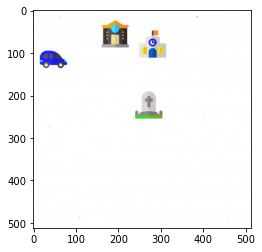

1


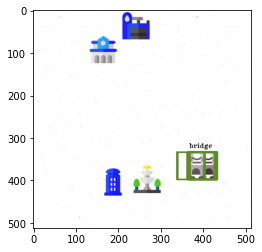

1


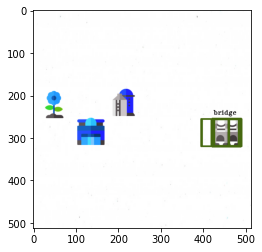

1


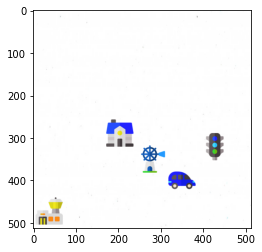

1


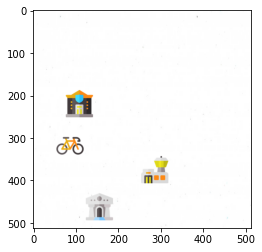

1


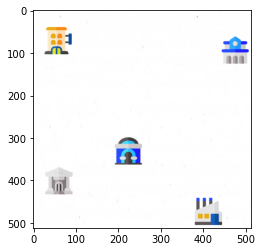

1


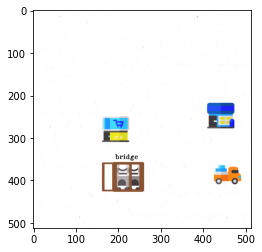

1


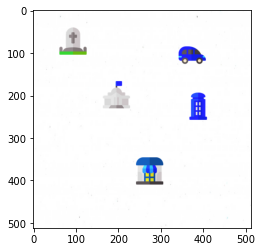

1


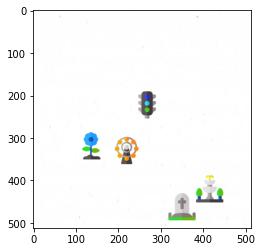

1


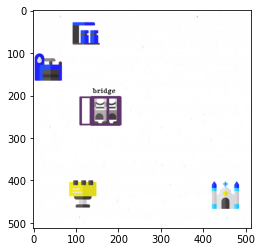

1


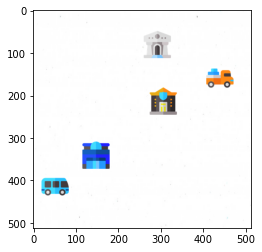

1


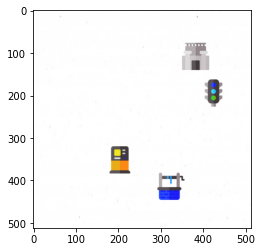

1


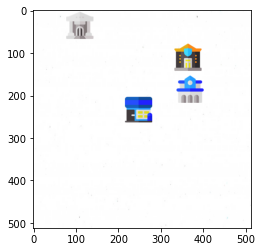

1


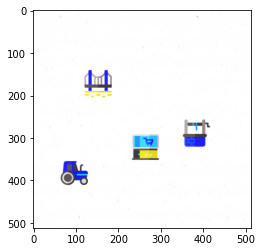

1


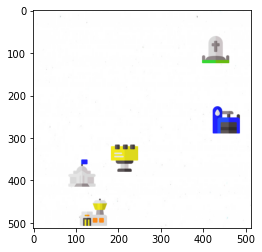

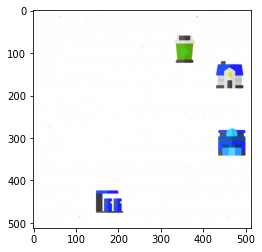

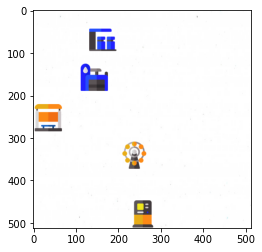

1


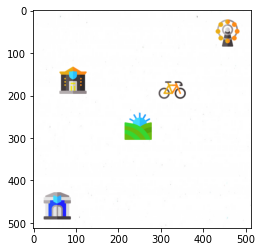

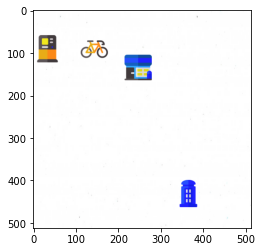

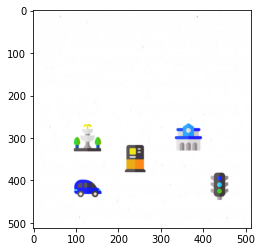

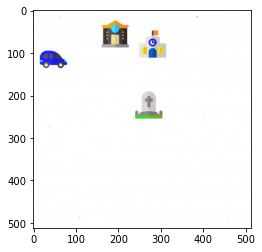

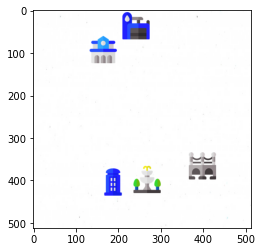

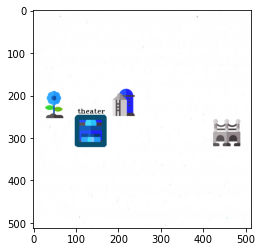

1


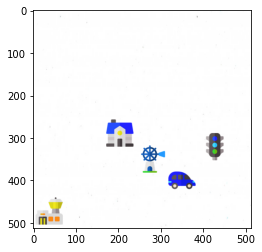

1


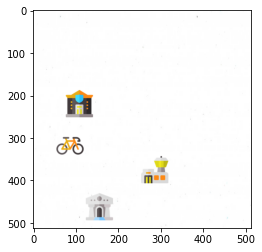

1


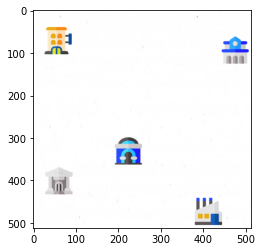

1


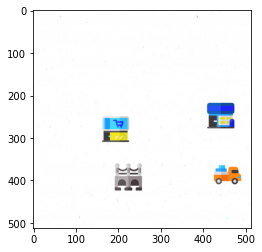

1


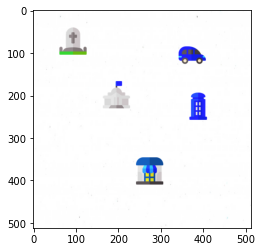

1


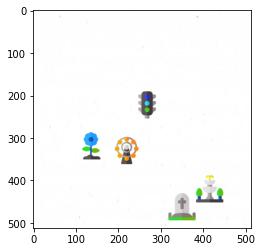

1


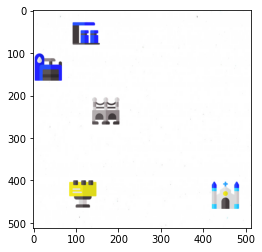

1


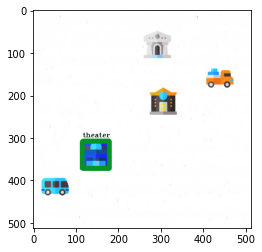

1


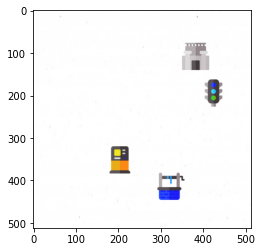

1


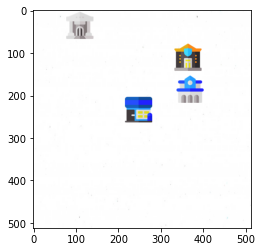

1


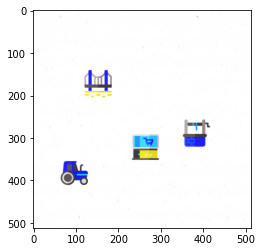

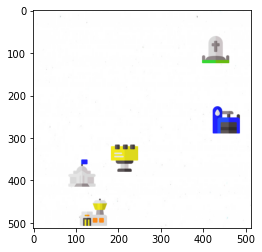

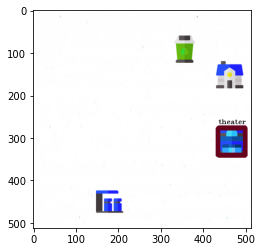

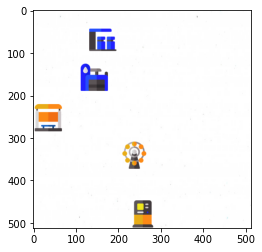

1


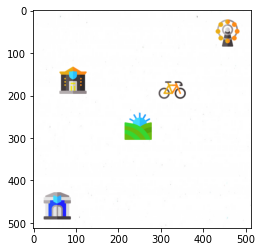

1


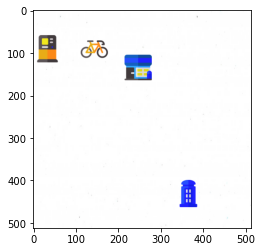

1


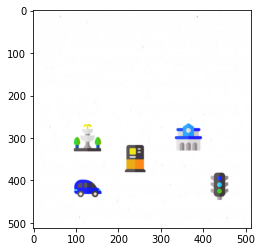

1


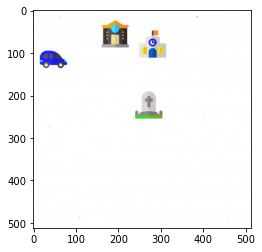

1


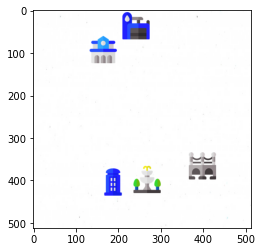

1


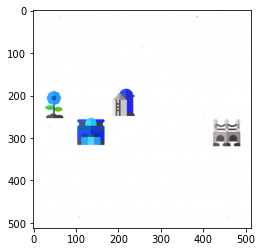

1


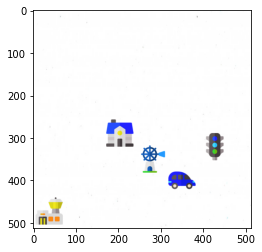

1


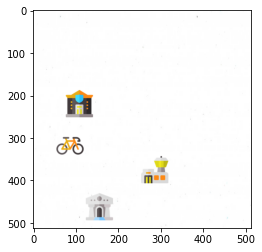

1


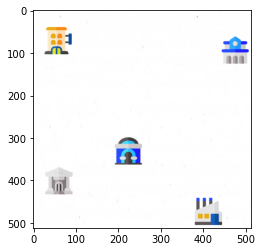

1


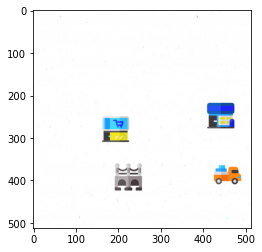

1


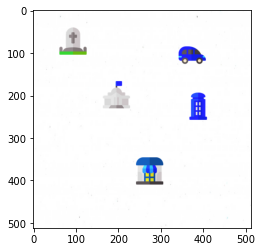

1


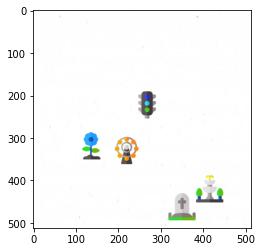

1


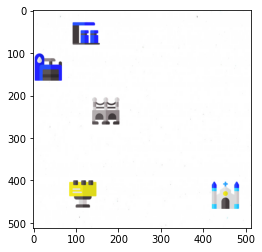

1


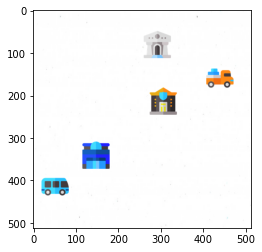

1


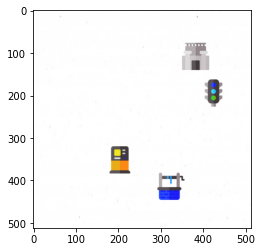

1


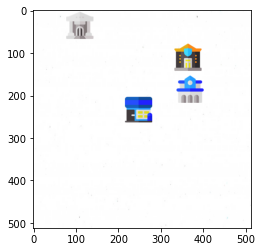

1


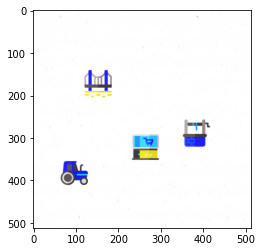

1


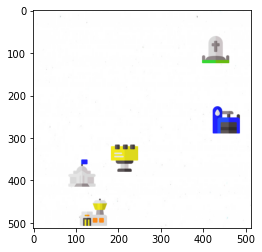

1


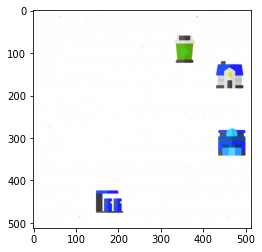

1


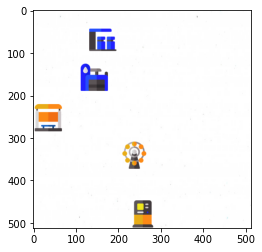

1


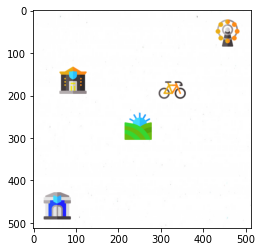

1


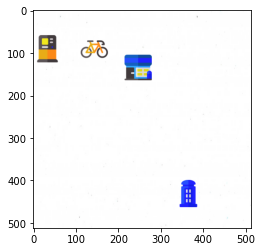

1


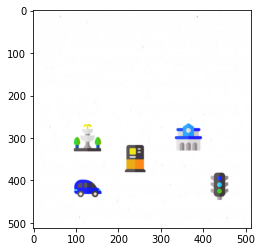

1


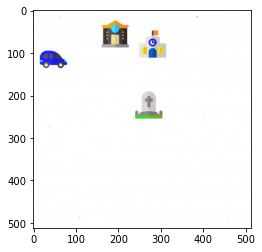

1


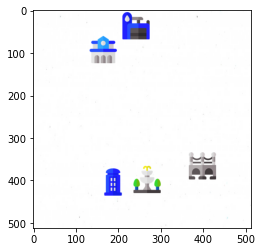

1


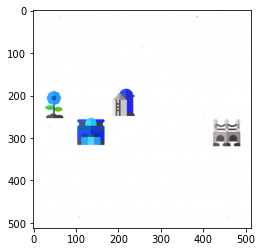

1


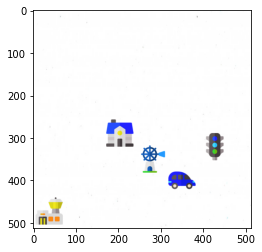

1


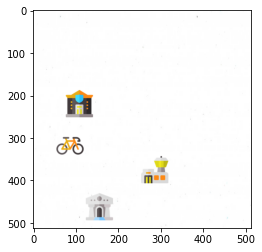

1


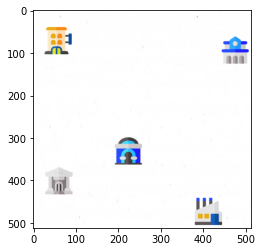

1


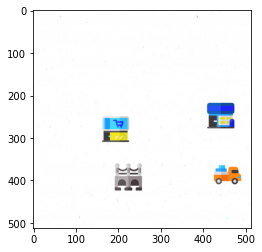

1


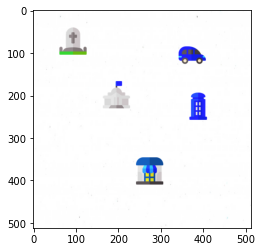

1


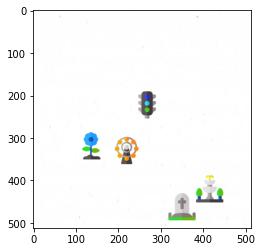

1


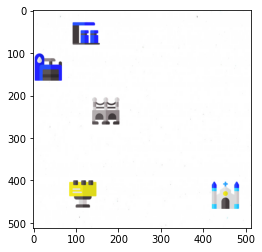

1


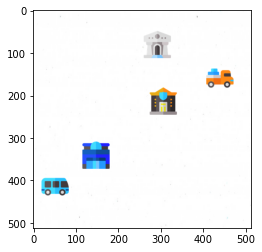

1


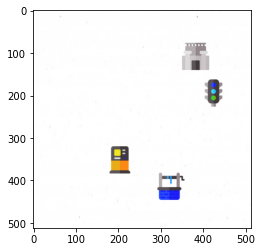

1


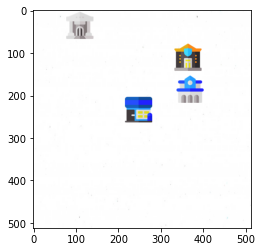

1


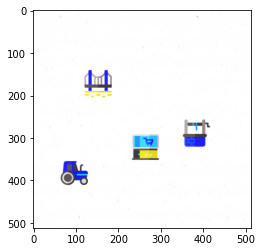

1


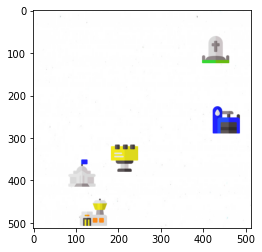

1


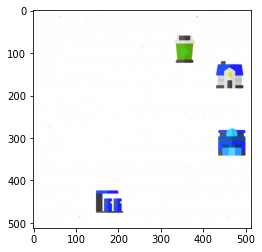

1


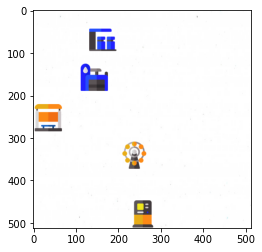

1


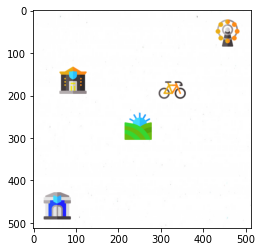

1


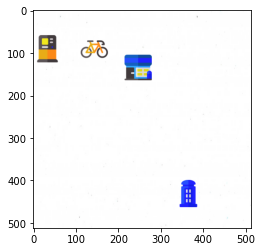

1


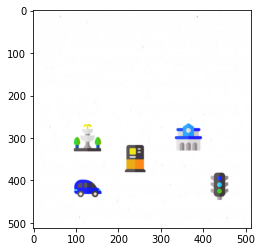

1


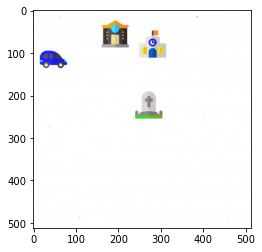

1


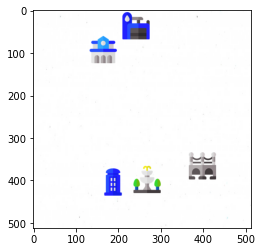

1


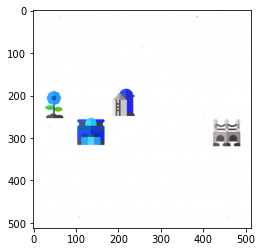

1


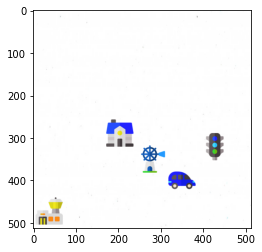

1


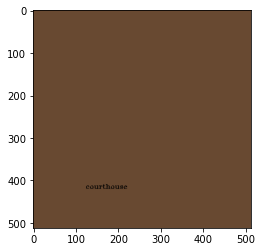

1


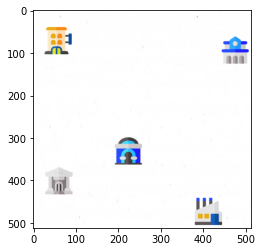

1


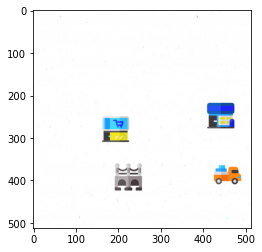

1


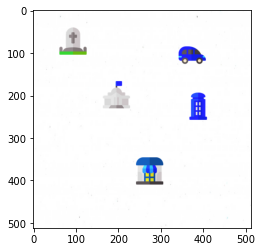

1


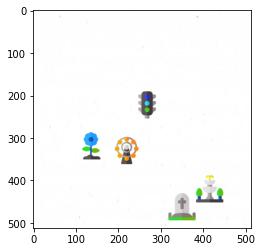

1


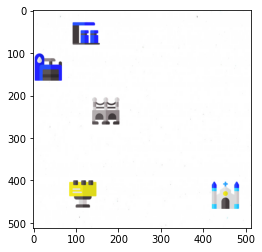

1


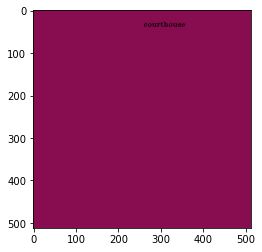

11


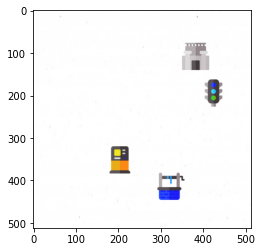

1


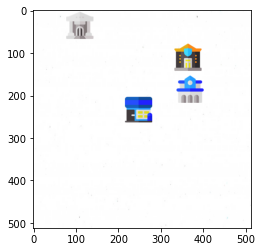

1


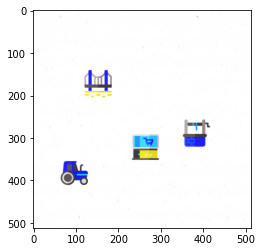

1


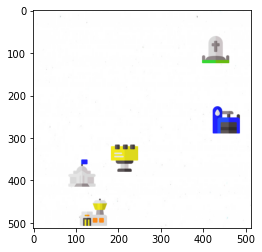

1


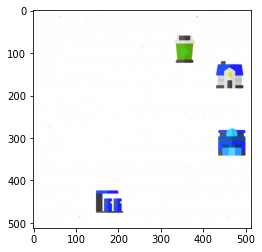

1


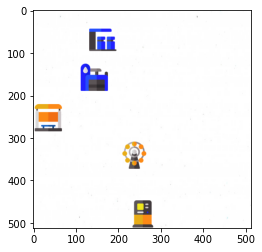

1


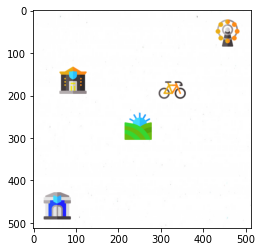

1


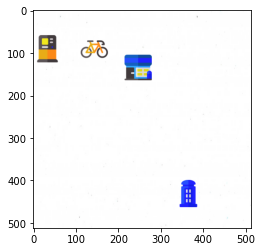

1


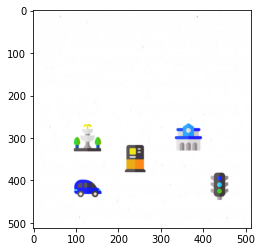

1


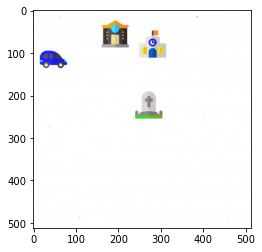

1


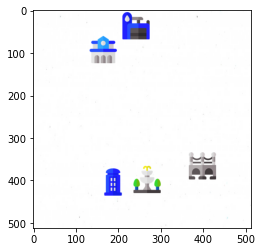

1


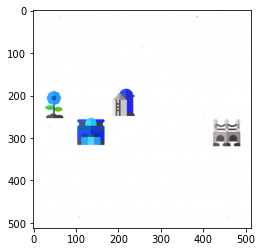

1


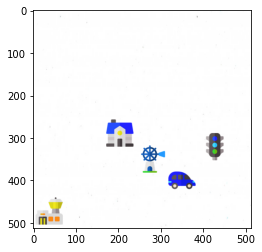

1


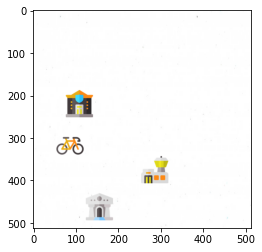

1


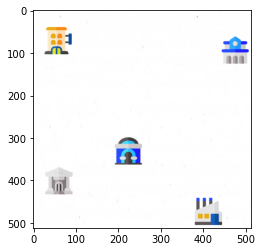

1


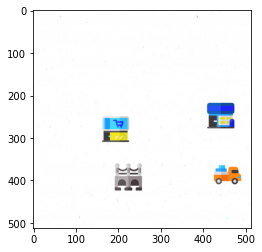

1


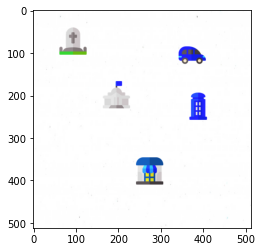

1


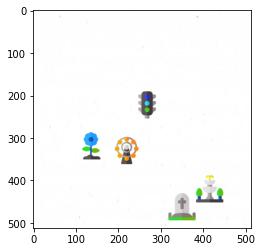

1


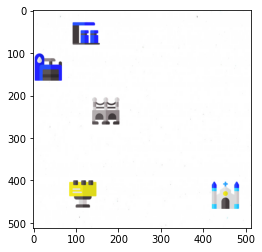

1


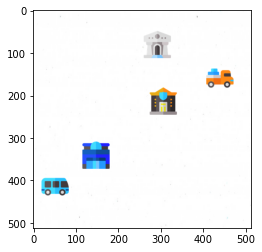

1


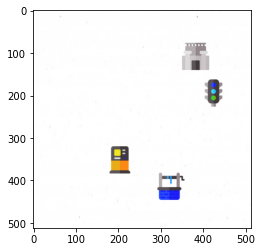

1


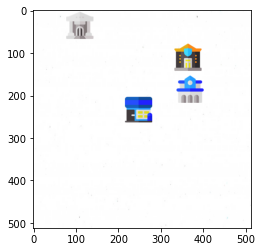

1


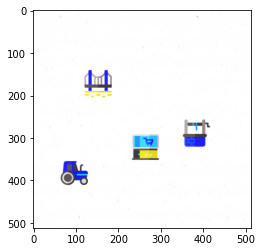

1


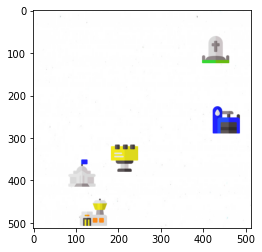

1


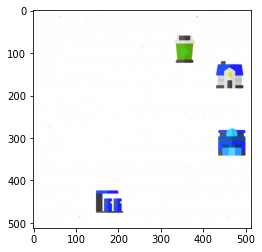

1


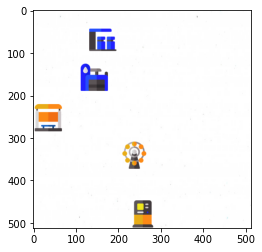

1


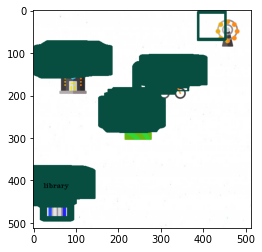

1


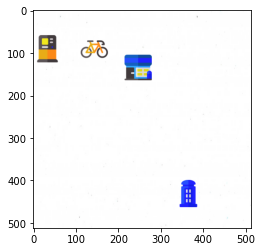

1


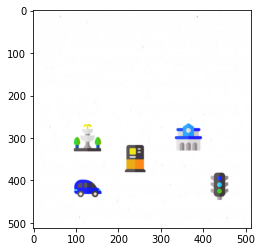

1


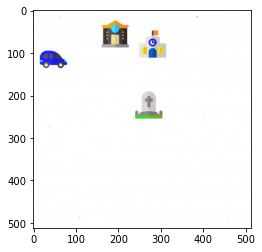

1


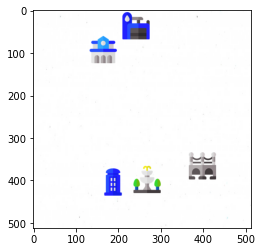

1


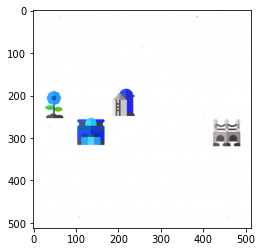

1


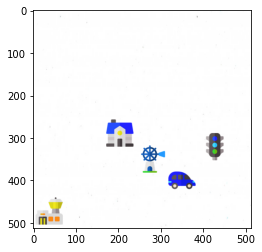

1


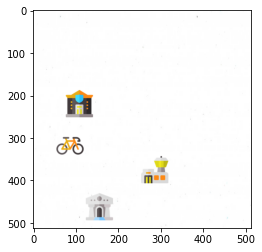

1


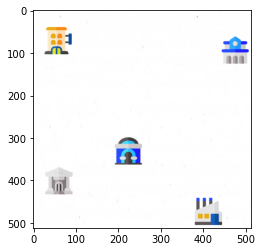

1


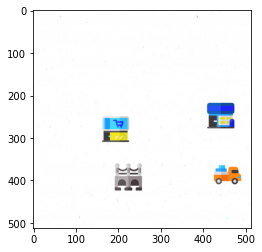

1


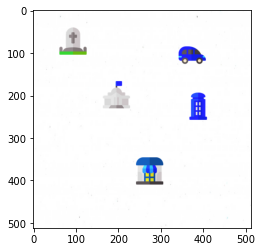

1


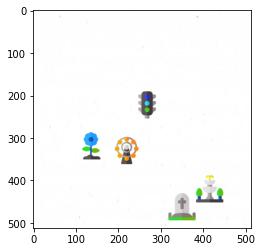

1


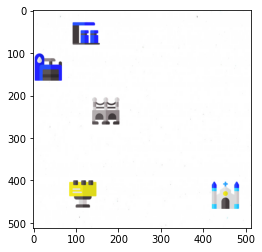

1


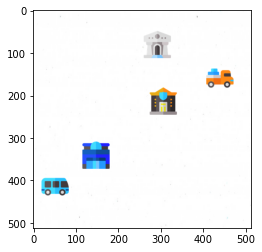

1


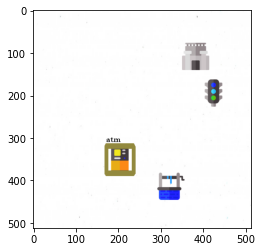

1


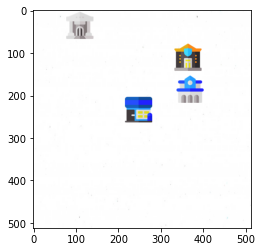

1


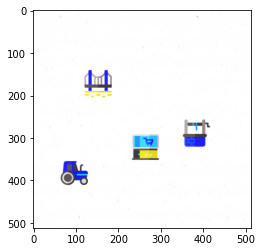

1


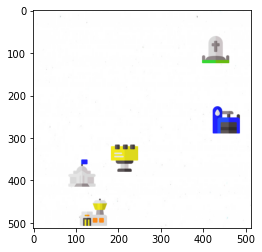

1


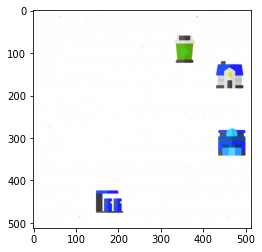

1


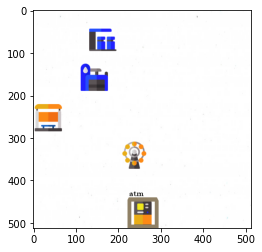

1


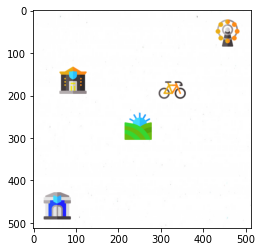

1


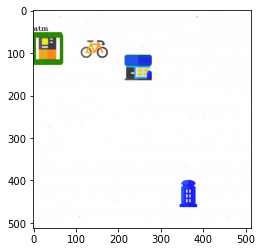

1


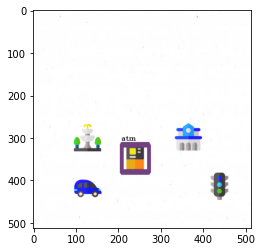

1


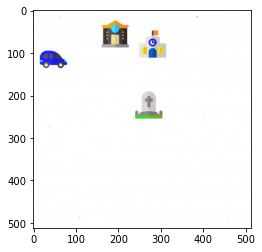

1


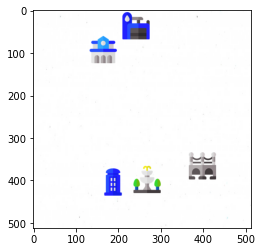

1


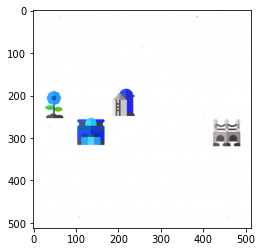

1


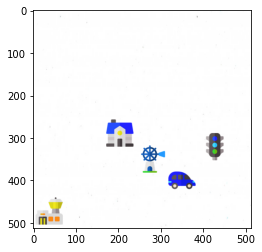

1


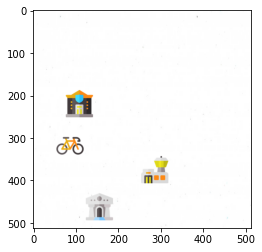

1


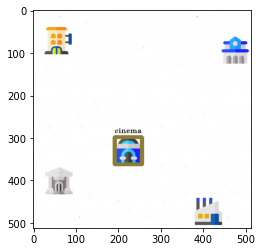

1


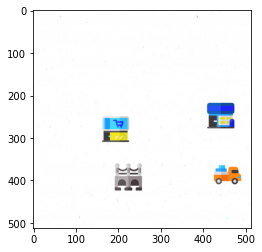

1


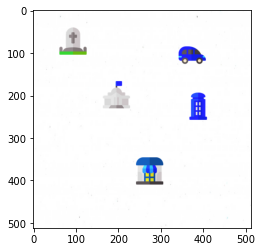

1


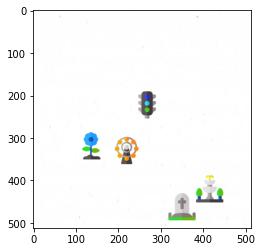

1


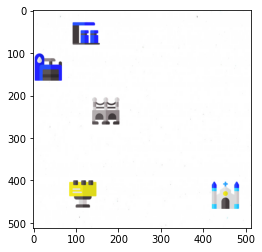

1


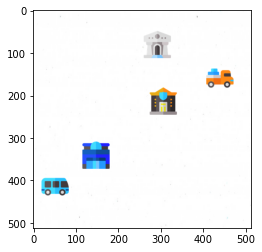

1


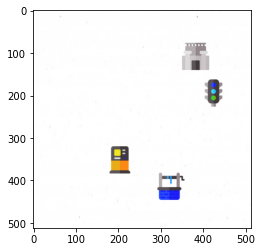

1


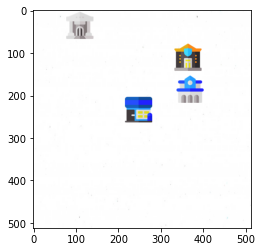

1


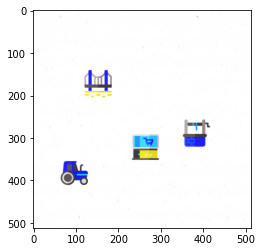

1


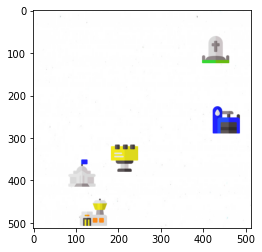

1


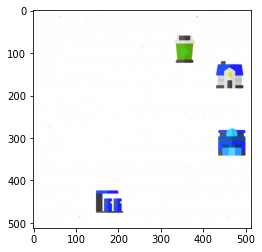

1


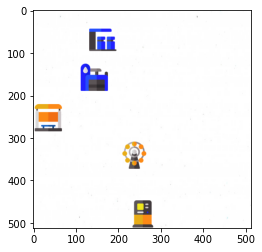

1


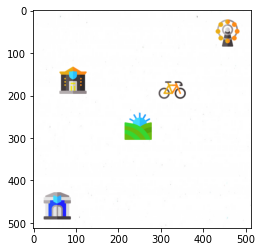

1


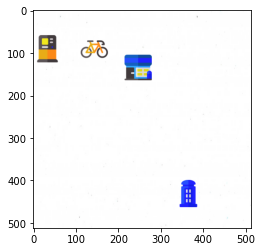

1


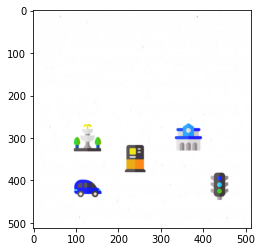

1


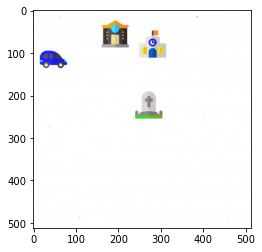

1


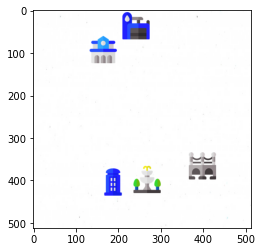

1


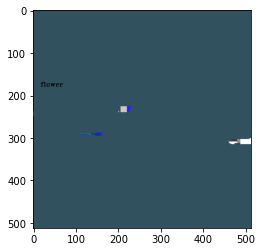

1


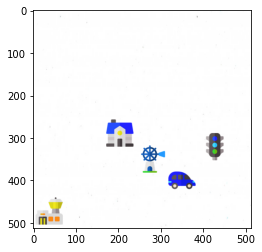

1


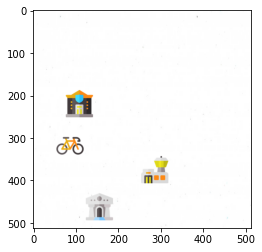

1


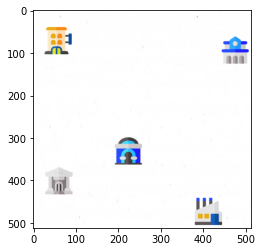

1


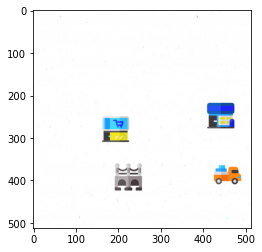

1


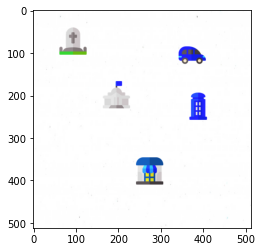

1


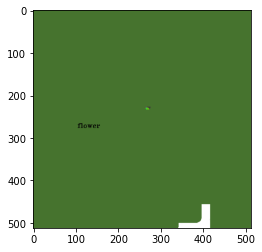

1


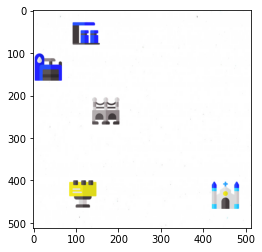

1


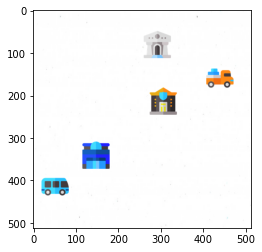

1


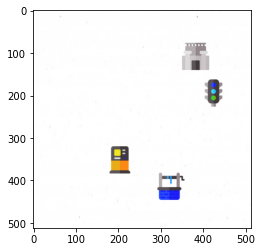

1


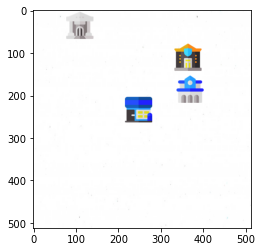

1


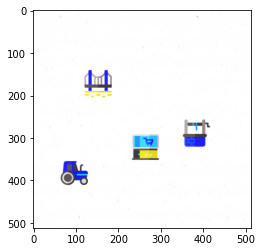

1


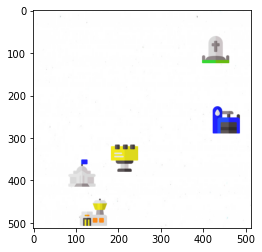

1


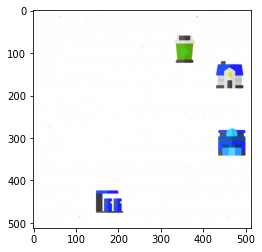

1


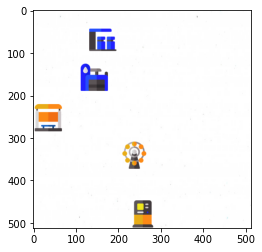

1


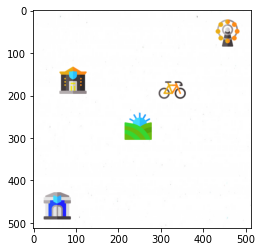

1


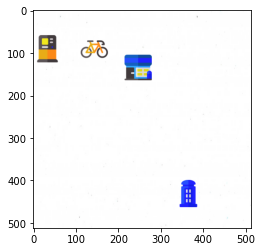

1


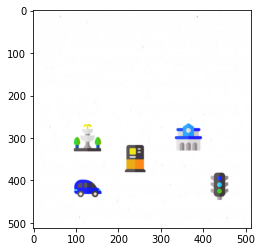

1


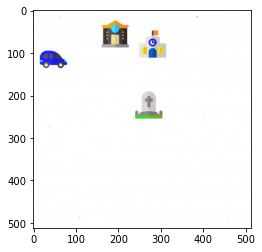

1


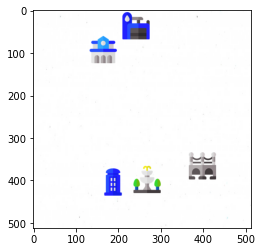

1


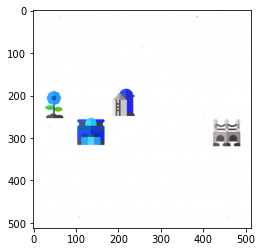

1


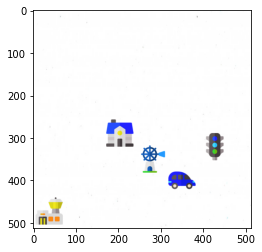

1


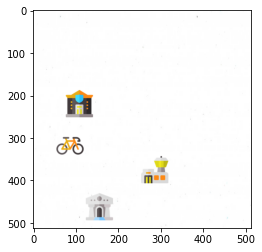

1


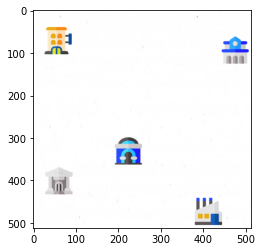

1


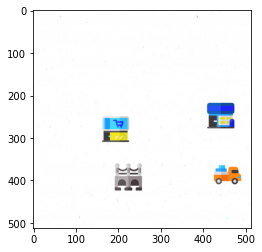

1


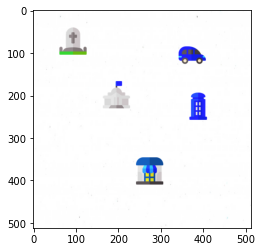

1


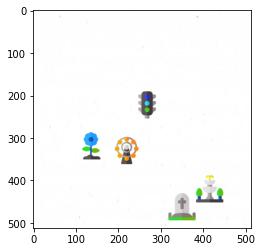

1


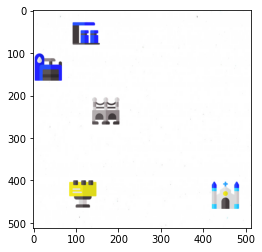

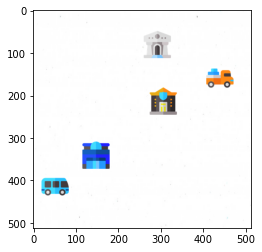

1


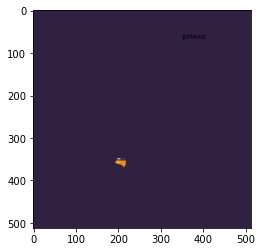

1


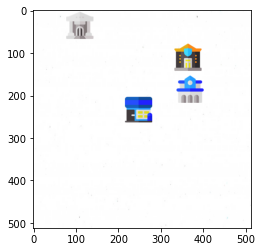

1


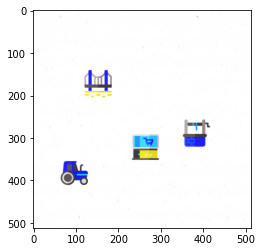

1


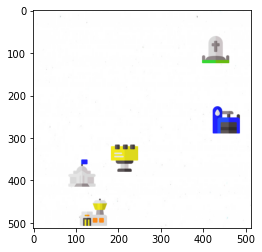

1


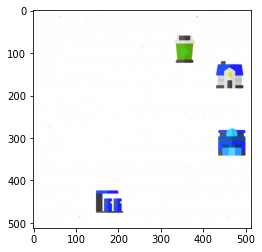

1


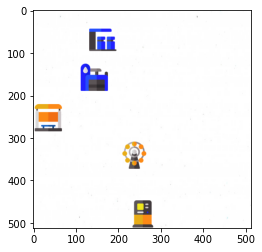

1


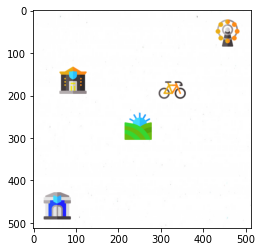

1


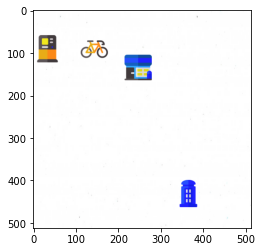

1


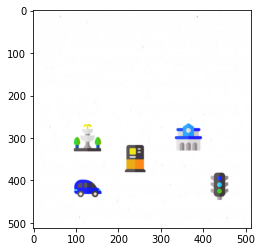

1


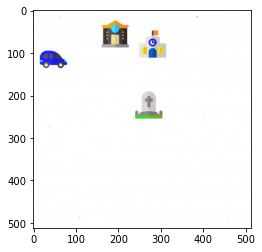

1


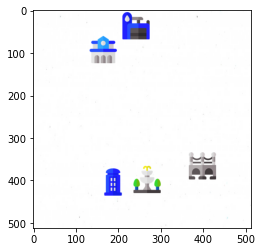

1


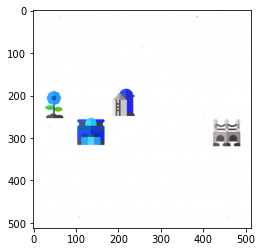

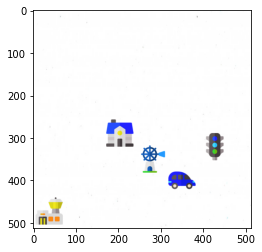

1


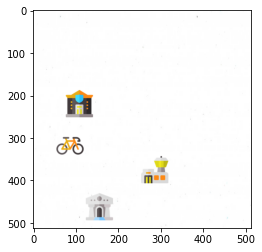

1


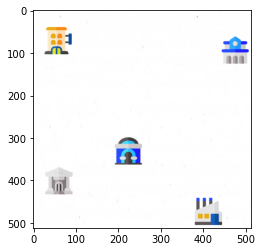

1


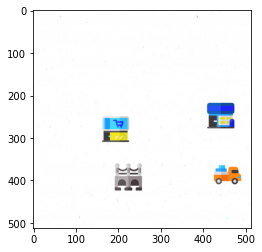

1


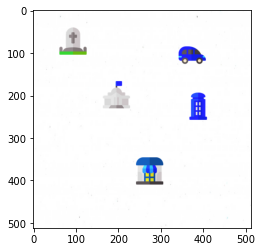

1


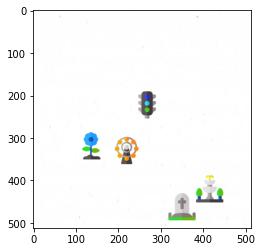

1


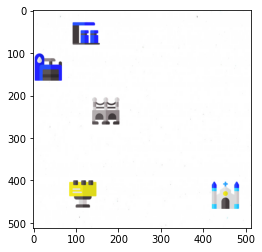

1


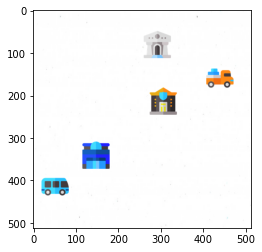

1


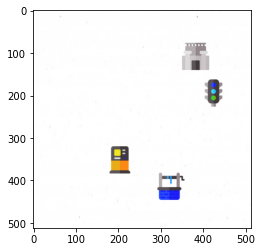

1


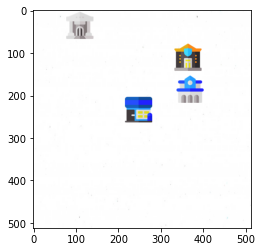

1


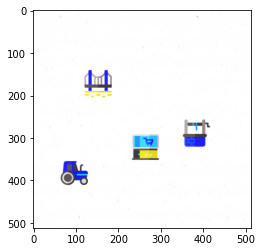

1


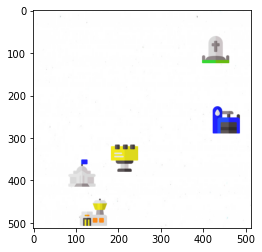

1


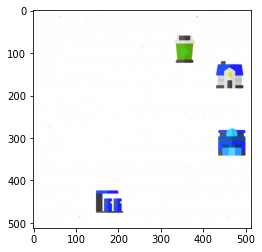

1


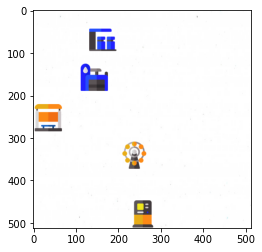

1


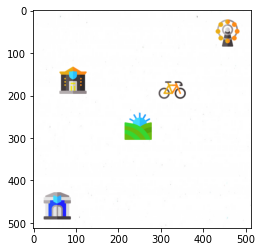

1


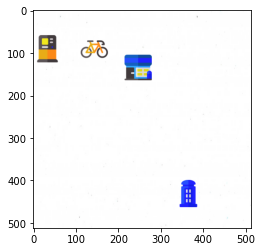

1


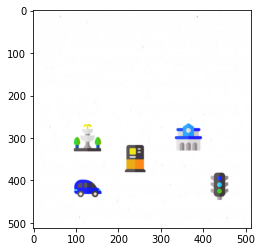

1


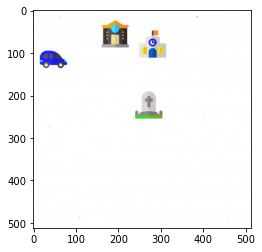

1


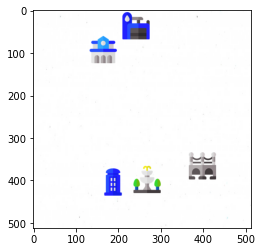

1


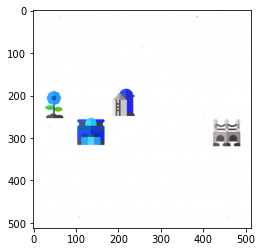

1


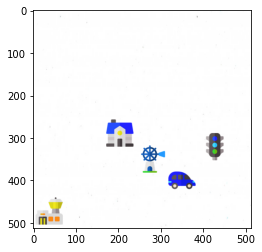

1


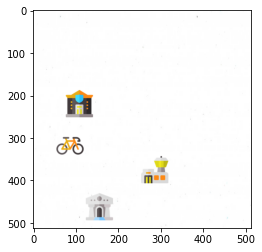

1


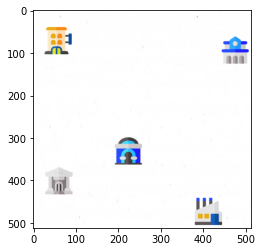

1


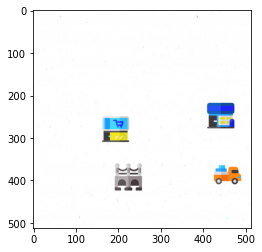

1


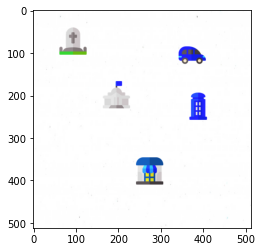

1


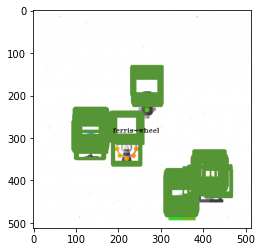

1


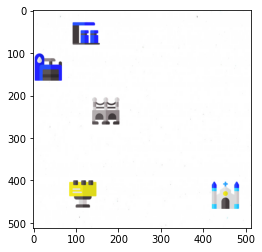

1


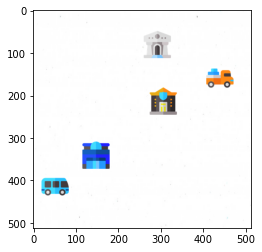

1


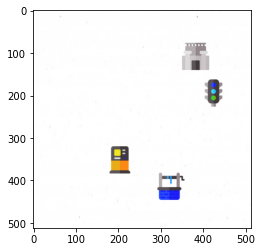

1


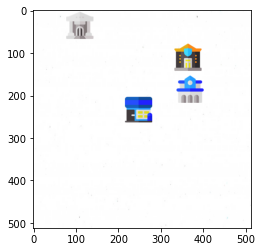

1


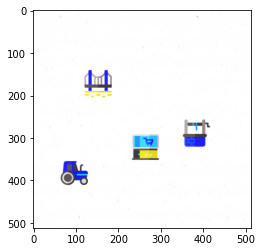

1


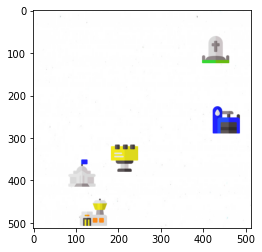

1


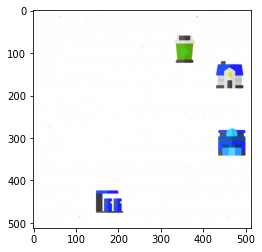

1


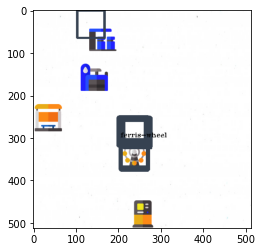

1


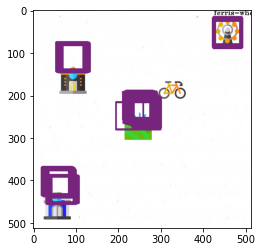

1


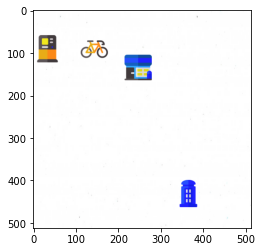

1


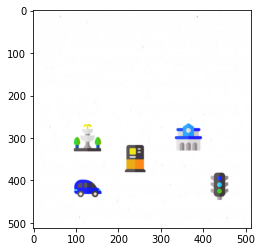

1


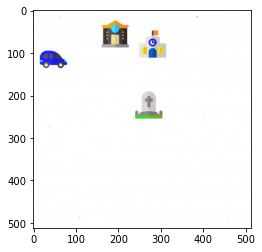

1


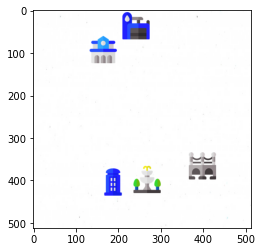

1


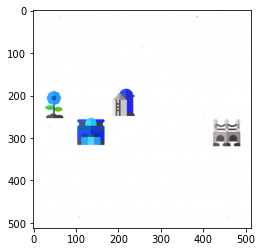

1


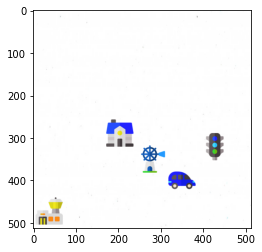

1


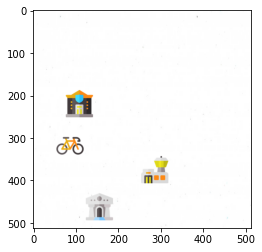

1


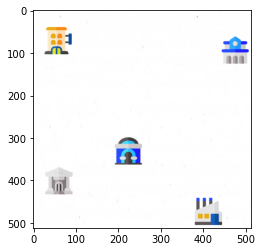

1


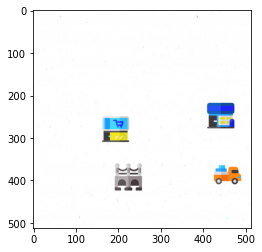

1


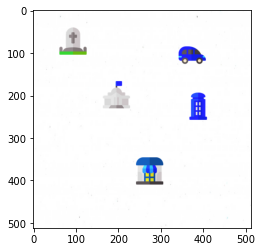

1


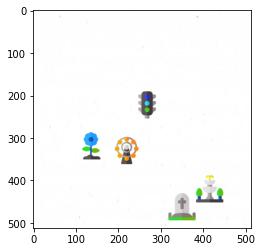

1


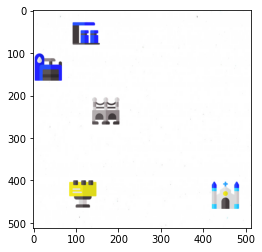

1


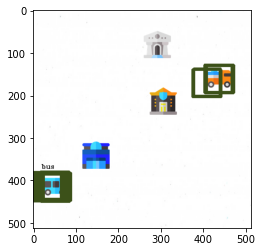

1


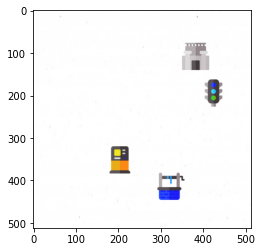

11


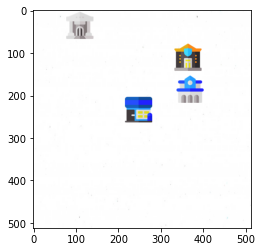

1


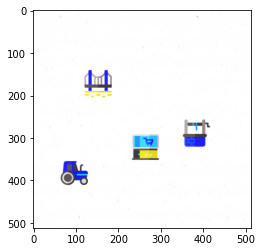

1


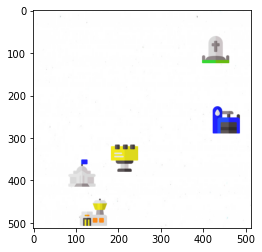

1


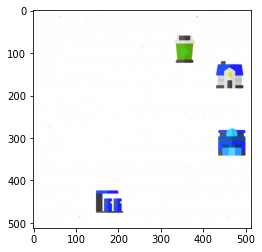

1


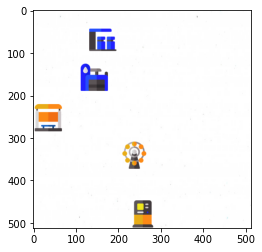

1


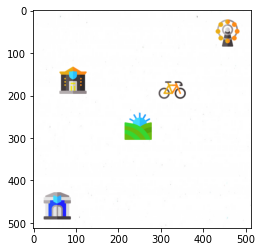

1


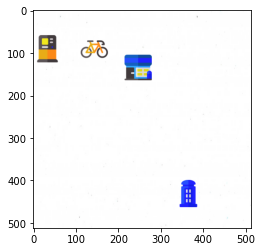

KeyboardInterrupt: Interrupted by user

In [153]:
for image in target_meth_results:
    plt.figure()
    plt.imshow(image)
    plt.show()
    results.append(input())

# 